In [2]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")


INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


In [67]:
data

card_present cellular     co2  current deployed  \
2019-11-04 00:00:01+00:00        False     True  1524.0    5.511     True   
2019-11-04 00:00:02+00:00         None     True  1109.0    5.981     True   
2019-11-04 00:00:03+00:00         None     True  1217.0      NaN     True   
2019-11-04 00:00:06+00:00        False     True  1584.0      NaN     True   
2019-11-04 00:00:07+00:00         None     True  2272.0    2.547     True   
...                                ...      ...     ...      ...      ...   
2020-01-24 00:15:01+00:00        False     True   967.0      NaN     True   
2020-01-24 00:15:17+00:00        False     True     NaN      NaN     True   
2020-01-24 00:15:33+00:00         True     True   454.0      NaN     True   
2020-01-24 00:16:01+00:00        False     True   964.0      NaN     True   
2020-01-24 00:17:01+00:00        False     True   964.0      NaN     True   

                          event fw_version  humidity           location  \
2019-11-04 00:00:01+00:00  mn/d          3      54.9  [47.935, 106.836]   
2019-11-04 00:00:02+00:00  mn/d          2      54.0  [47.936, 106.834]   
2019-11-04 00:00:03+00:00  mn/d          2      69.2   [47.927, 106.83]   
2019-11-04 00:00:06+00:00  mn/d          3      48.4   [47.937, 106.84]   
2019-11-04 00:00:07+00:00  mn/d          2      40.6  [47.935, 106.836]   
...                         ...        ...       ...                ...   
2020-01-24 00:15:01+00:00  mn/d          3      18.2  [47.922, 106.823]   
2020-01-24 00:15:17+00:00  mn/d          3       NaN               None   
2020-01-24 00:15:33+00:00  mn/d          3      19.1  [47.917, 106.829]   
2020-01-24 00:16:01+00:00  mn/d          3      18.2  [47.922, 106.823]   
2020-01-24 00:17:01+00:00  mn/d          3      18.2  [47.922, 106.823]   

                          location_name  ... reset_reason_data  \
2019-11-04 00:00:01+00:00      Mongolia  ...               NaN   
2019-11-04 00:00:02+00:00      Mongolia  ...               NaN   
2019-11-04 00:00:03+00:00      Mongolia  ...               NaN   
2019-11-04 00:00:06+00:00      Mongolia  ...               NaN   
2019-11-04 00:00:07+00:00      Mongolia  ...               NaN   
...                                 ...  ...               ...   
2020-01-24 00:15:01+00:00      Mongolia  ...               NaN   
2020-01-24 00:15:17+00:00      Mongolia  ...               NaN   
2020-01-24 00:15:33+00:00      Mongolia  ...               NaN   
2020-01-24 00:16:01+00:00      Mongolia  ...               NaN   
2020-01-24 00:17:01+00:00      Mongolia  ...               NaN   

                          rtc_temperature                 sensor_id sequence  \
2019-11-04 00:00:01+00:00             NaN  e00fce686c8734b91819de91    66436   
2019-11-04 00:00:02+00:00           29.50  e00fce68068d755f7bf0ec7b    66392   
2019-11-04 00:00:03+00:00           17.75  e00fce68fad0292979e94e3e    61592   
2019-11-04 00:00:06+00:00           27.50  e00fce68cbf6aec1112a30c0    63904   
2019-11-04 00:00:07+00:00           32.50  e00fce68c77425e3c1e14821    20769   
...                                   ...                       ...      ...   
2020-01-24 00:15:01+00:00           27.00  e00fce68189c74034137ad0d   145512   
2020-01-24 00:15:17+00:00           19.75  e00fce687bf925e55a89a6c6    43270   
2020-01-24 00:15:33+00:00           24.50  e00fce686ec1c40e79b5657d   131868   
2020-01-24 00:16:01+00:00           27.25  e00fce68189c74034137ad0d   145513   
2020-01-24 00:17:01+00:00           27.25  e00fce68189c74034137ad0d   145514   

                             serial_number  stay_at_home  \
2019-11-04 00:00:01+00:00  B31KAB9106NA4SG          True   
2019-11-04 00:00:02+00:00  B31KAB913CUH4MY          True   
2019-11-04 00:00:03+00:00  B31KAB9134ACERV         False   
2019-11-04 00:00:06+00:00  B31KAB913G5AWSR         False   
2019-11-04 00:00:07+00:00  B31KAB913XVT47R         False   
...                                    ...           ...   
2020-01-24 00:15:01+00:00 

In [49]:
num_bins = 10
n, bins, patches = plt.hist(data.voltage.values, num_bins, facecolor='blue', alpha=0.5)
plt.show()

2019-11-04 00:00:01+00:00     62.0
2019-11-04 00:00:02+00:00      2.0
2019-11-04 00:00:03+00:00     18.0
2019-11-04 00:00:06+00:00      8.0
2019-11-04 00:00:07+00:00     13.0
                             ...  
2020-01-24 00:15:01+00:00    111.0
2020-01-24 00:15:17+00:00      NaN
2020-01-24 00:15:33+00:00     18.0
2020-01-24 00:16:01+00:00    110.0
2020-01-24 00:17:01+00:00    112.0
Name: pm2_5, Length: 3915170, dtype: float64

In [148]:
# data = data[data.pm2_5 >= 0]

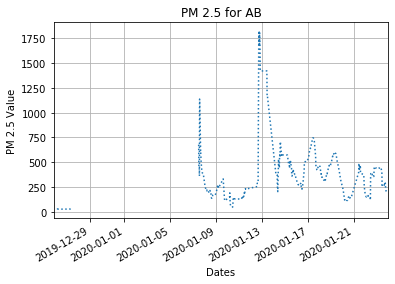

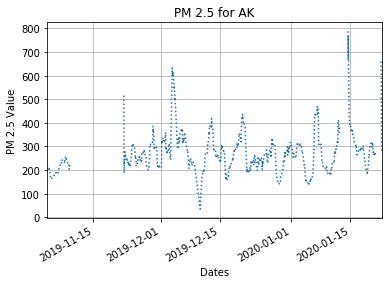

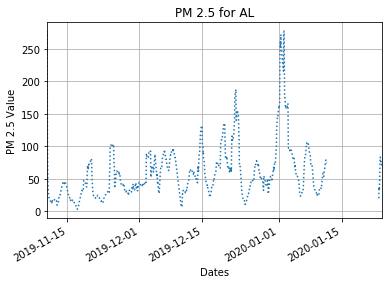

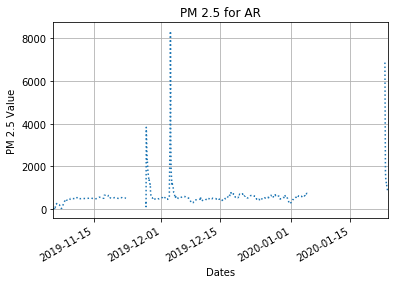

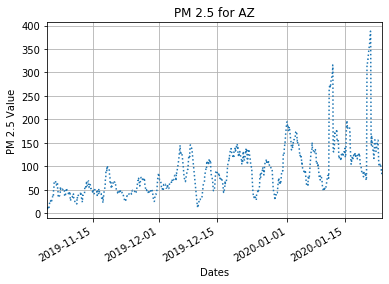

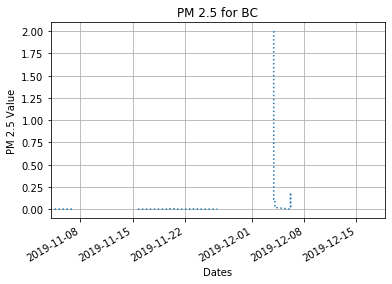

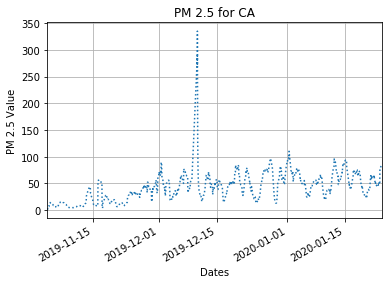

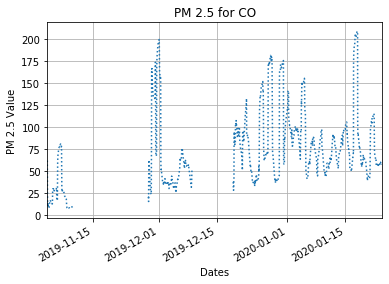

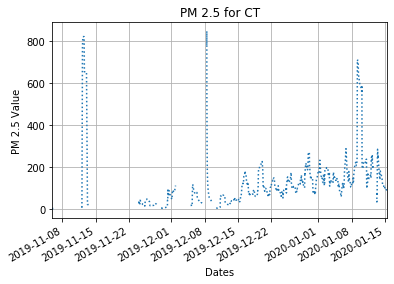

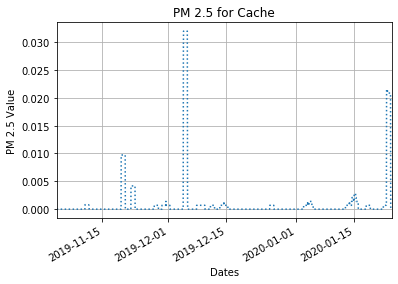

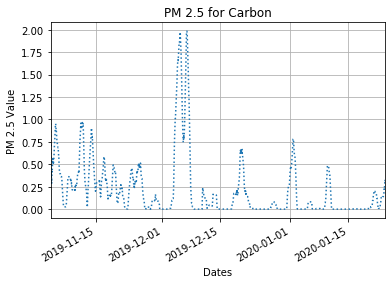

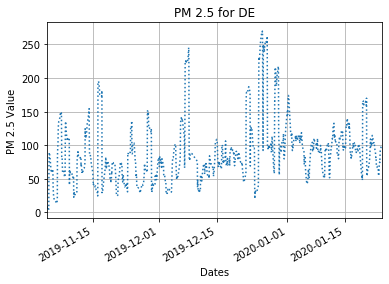

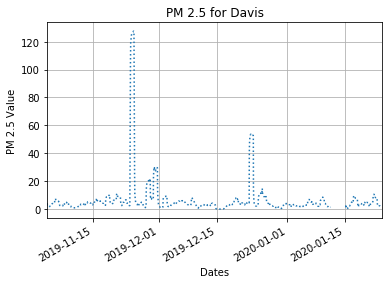

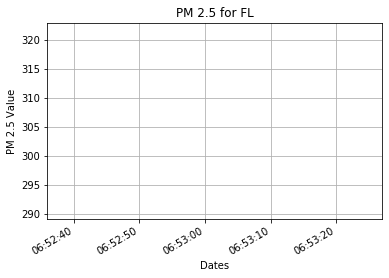

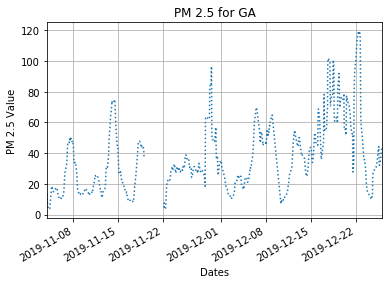

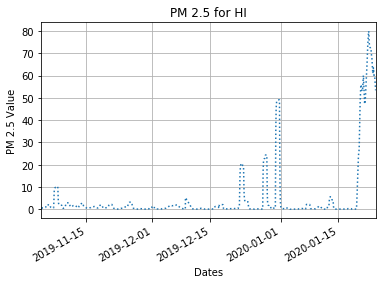

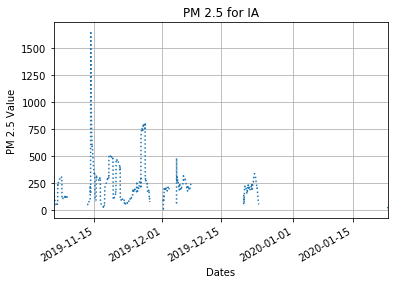

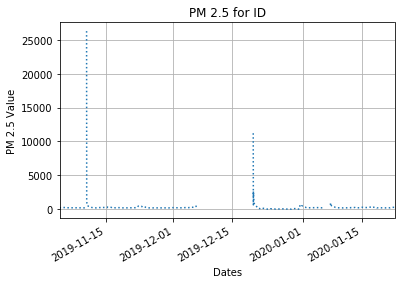

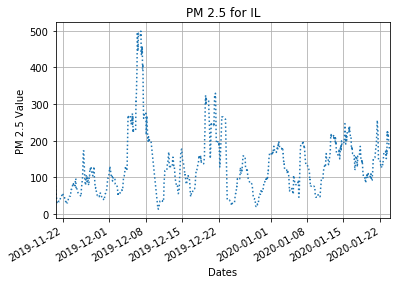

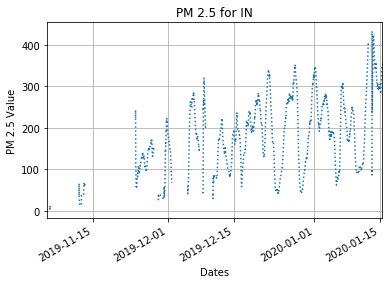

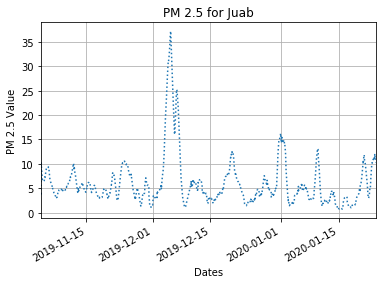

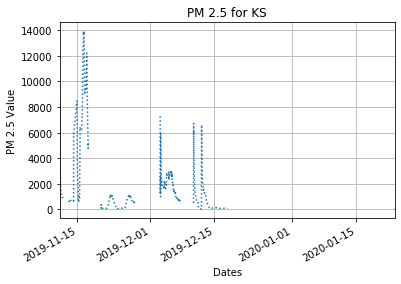

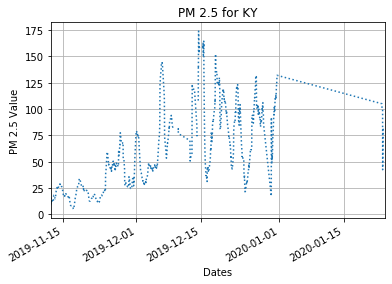

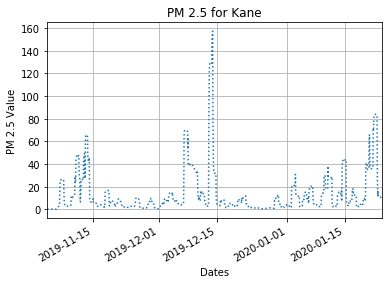

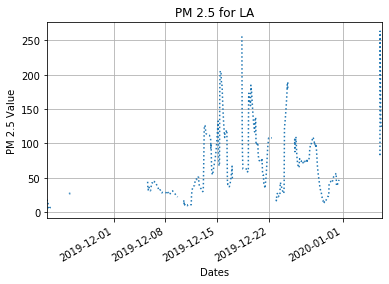

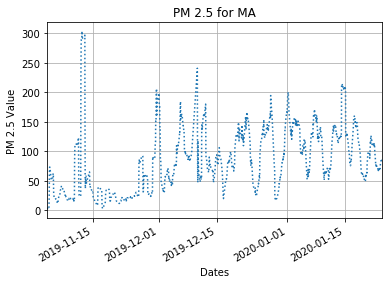

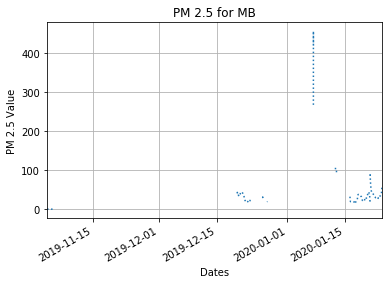

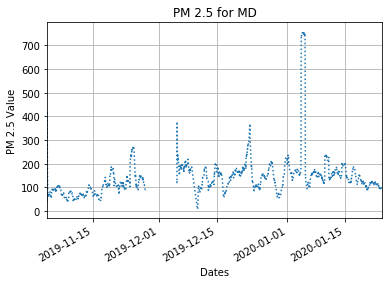

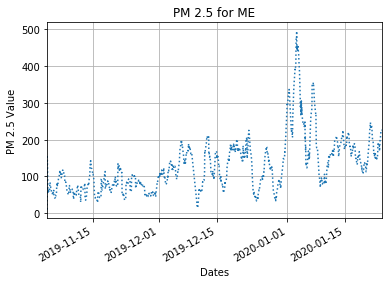

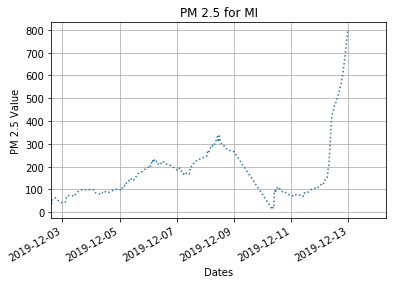

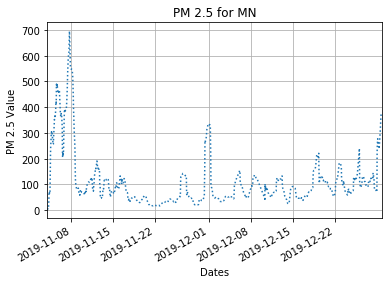

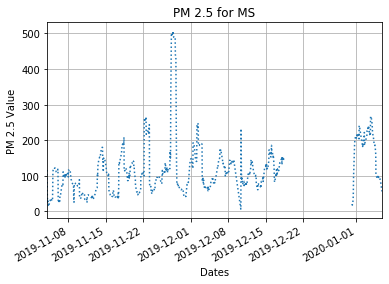

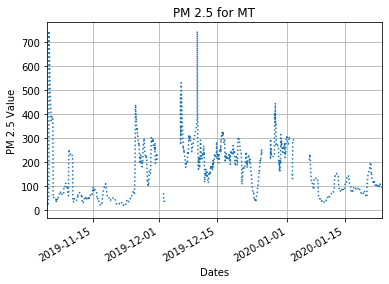

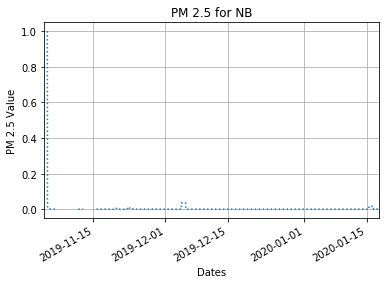

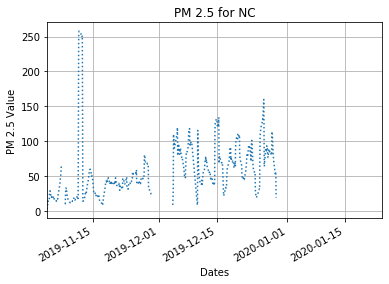

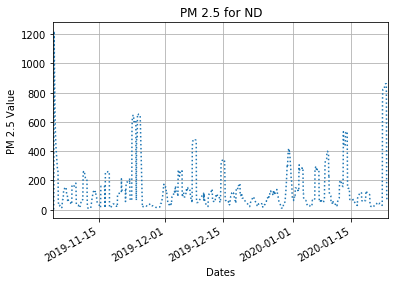

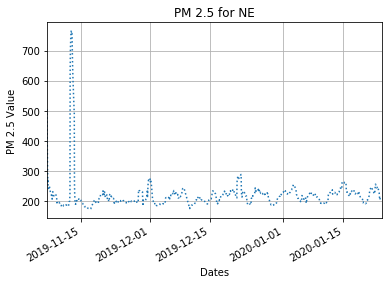

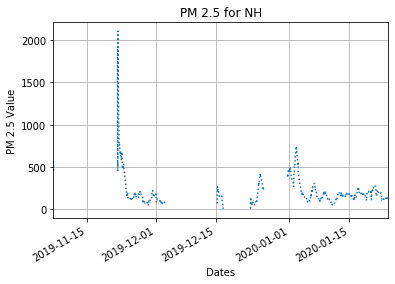

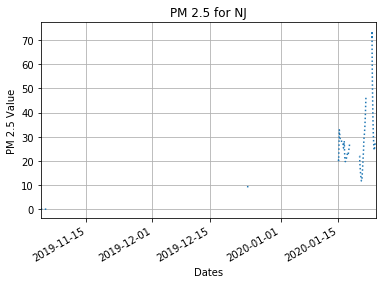

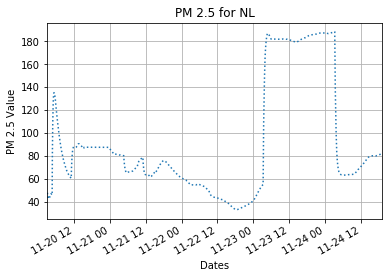

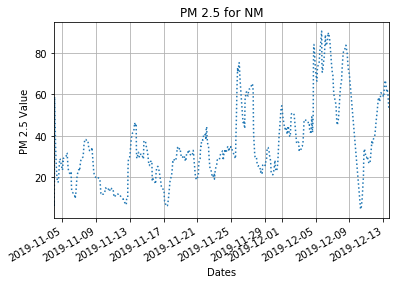

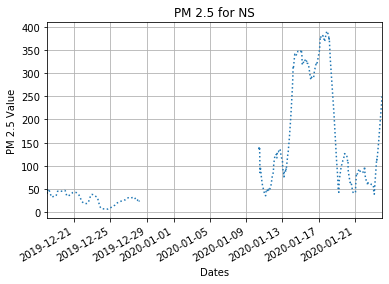

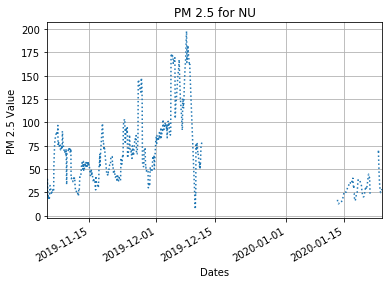

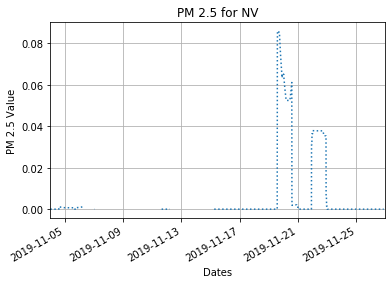

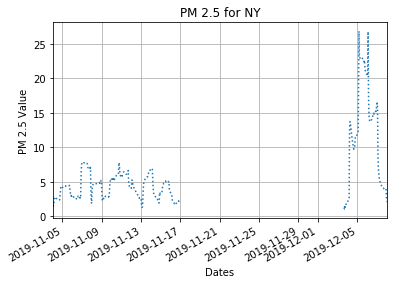

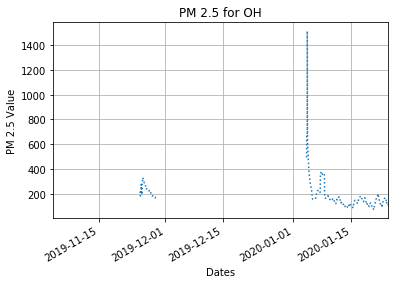

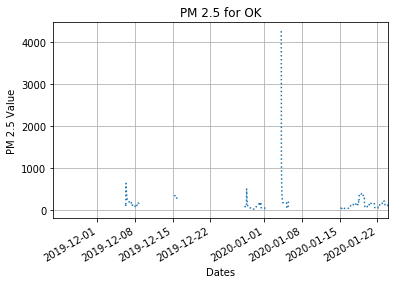

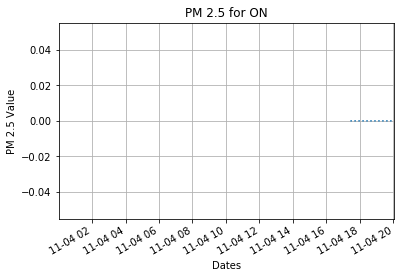

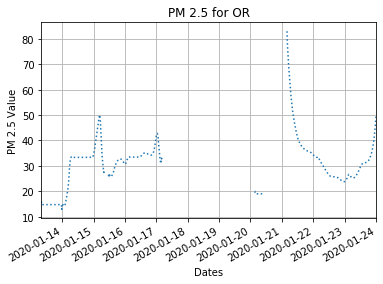

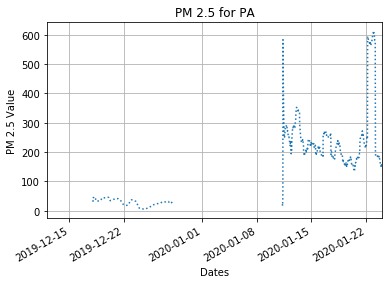

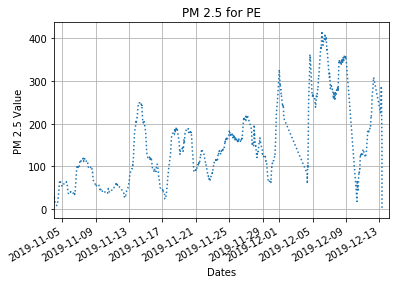

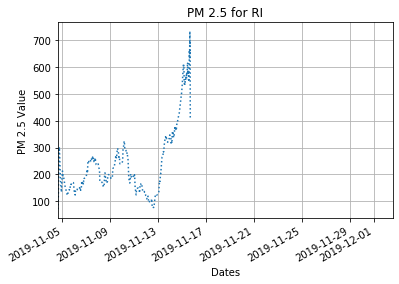

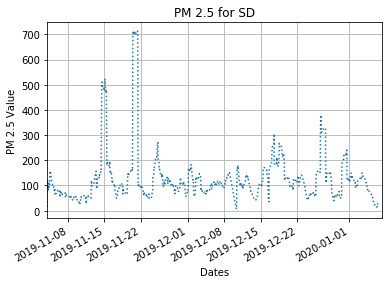

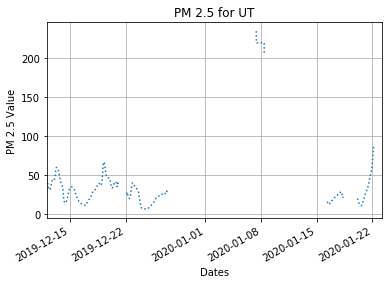

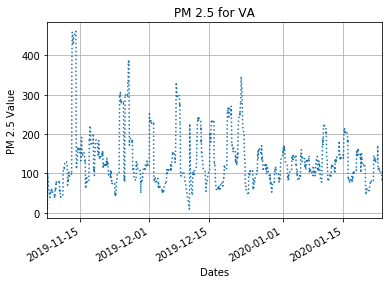

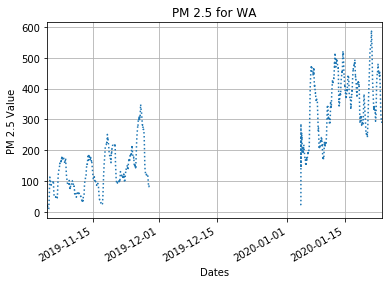

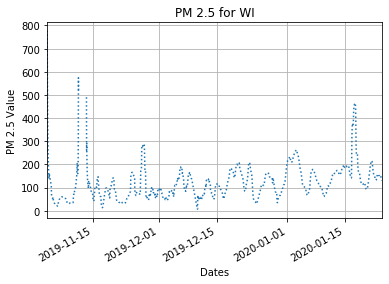

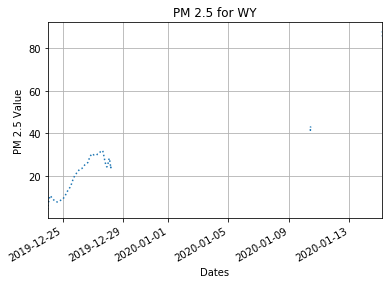

In [154]:
# for name, sensor_data in data.groupby("name"):
#     print("Sensor:", name)
#     sensor_data["pm2_5"].rolling("10d").mean().plot()

for name, sensor_data in data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.savefig("./trends/{}_pm_2_5.png".format(name), format='png')
    plt.show()

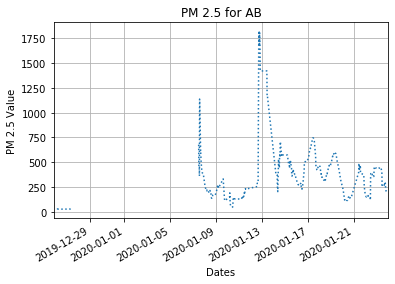

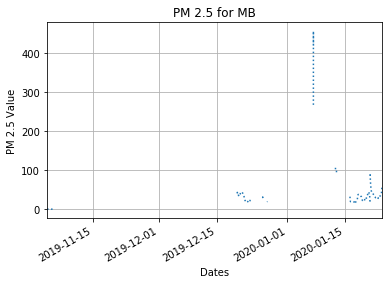

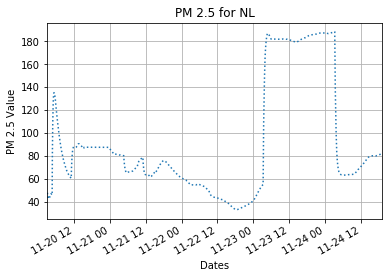

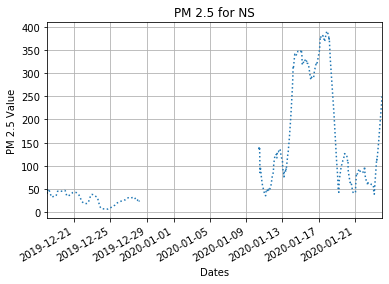

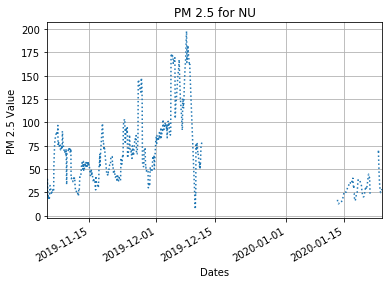

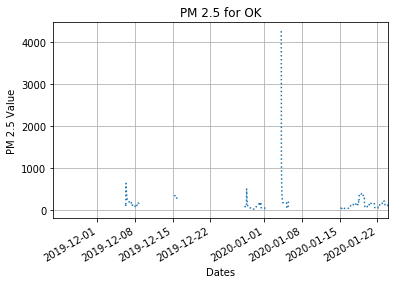

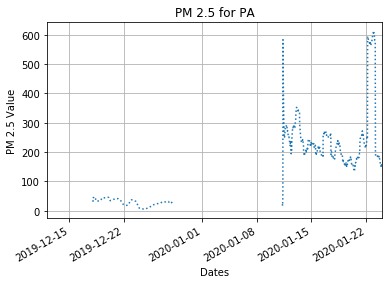

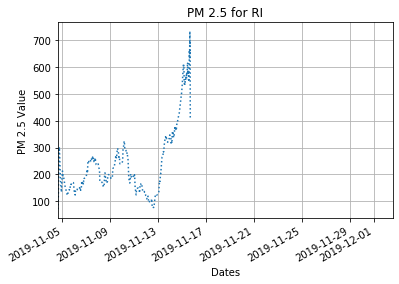

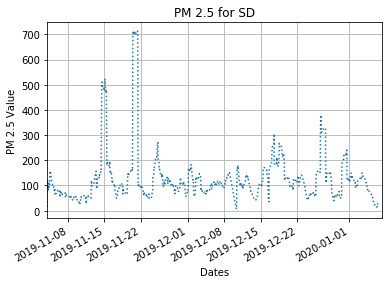

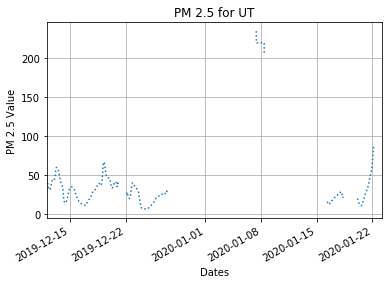

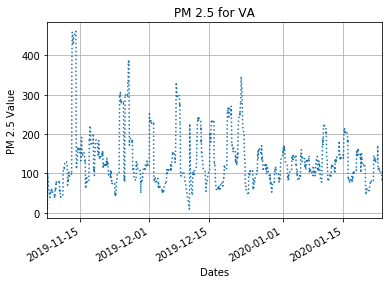

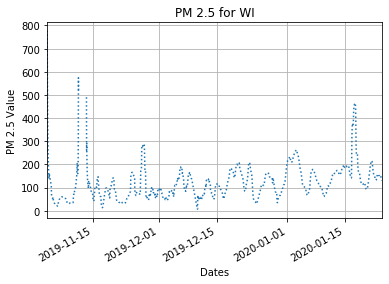

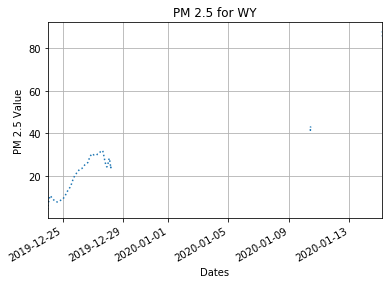

In [182]:
# this set is for daily PM 2.5 average for all unmodified gers
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

unmodified_gers = ['AB', 'MB', 'NL', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI', 'WY']
data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10]) | (data.name == unmodified_gers[11]) | (data.name == unmodified_gers[12])]

for name, sensor_data in data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.savefig("./unmodified_gers_pm_2_5/{}_pm_2_5.png".format(name), format='png')
    plt.show()
    
data = gold_data

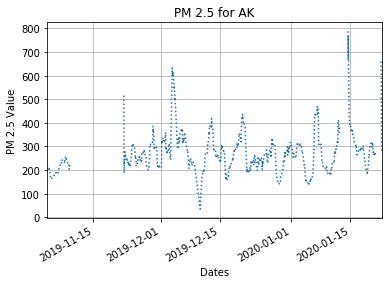

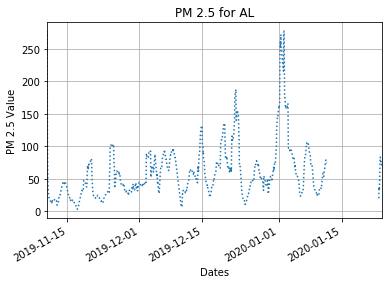

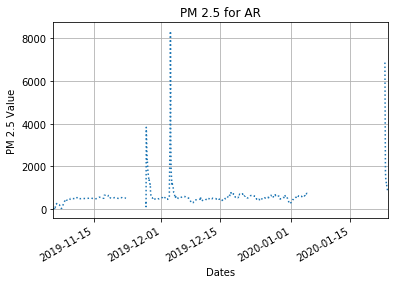

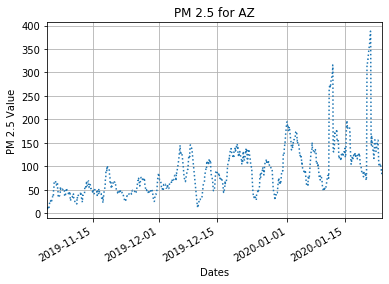

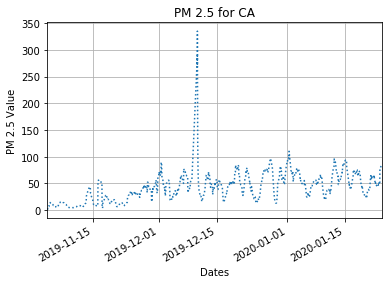

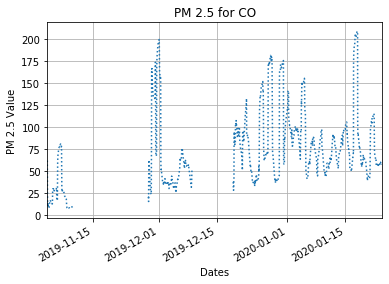

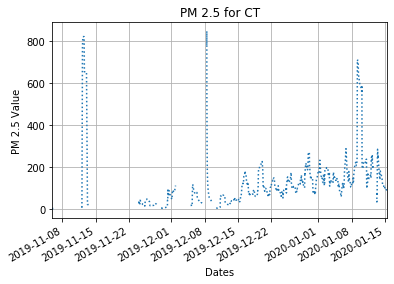

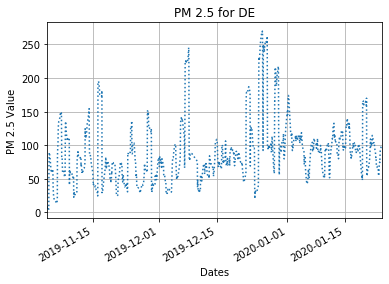

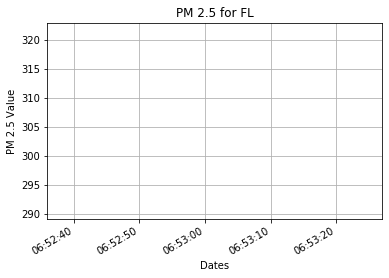

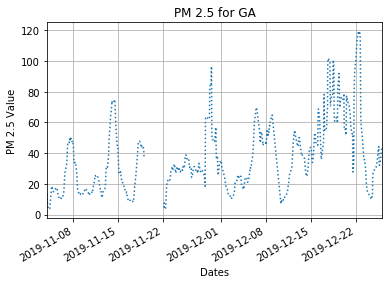

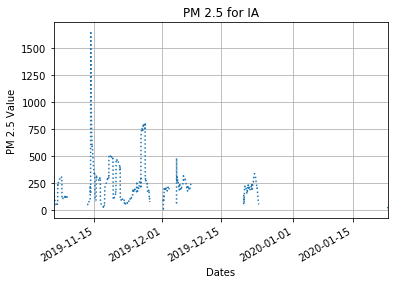

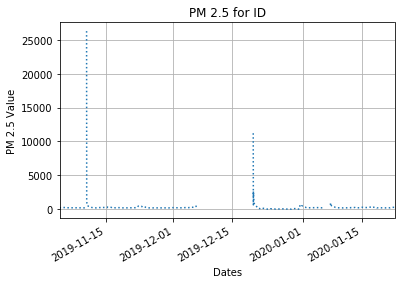

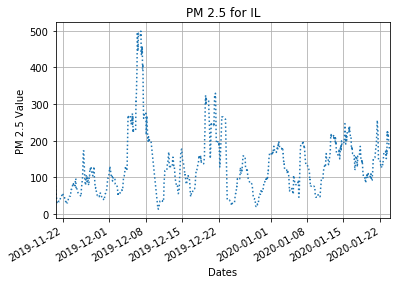

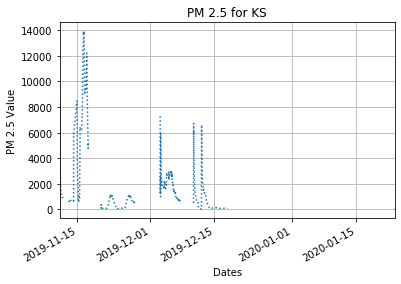

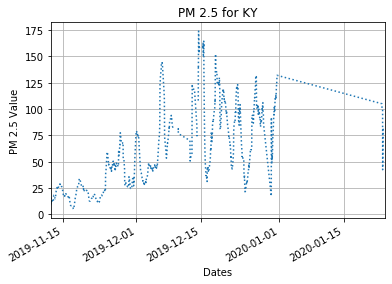

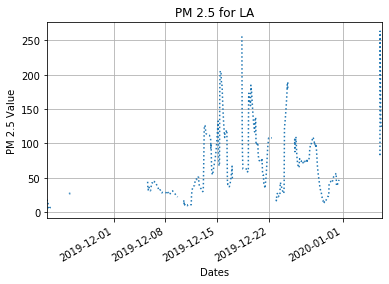

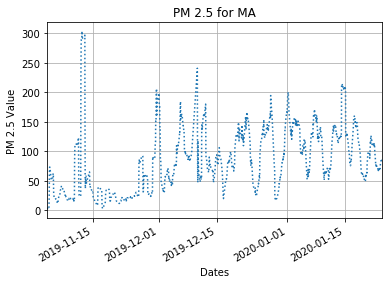

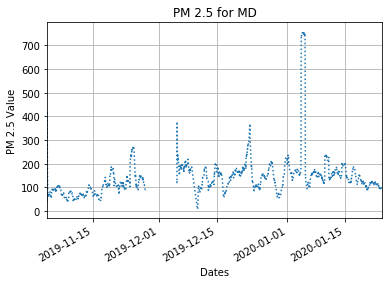

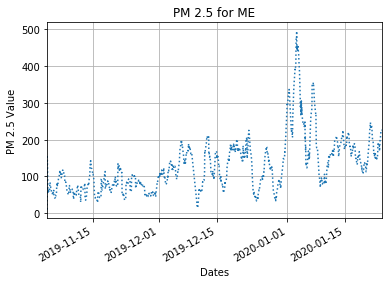

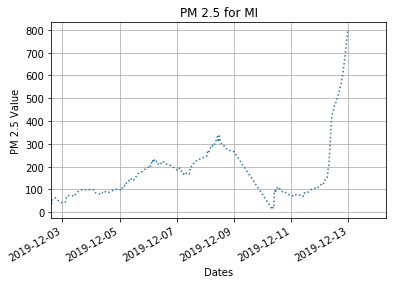

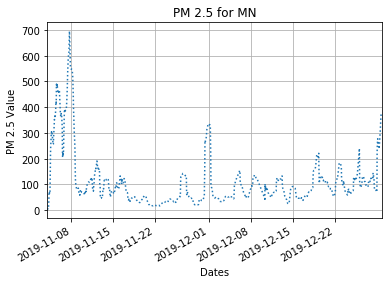

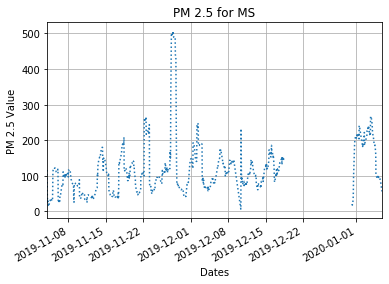

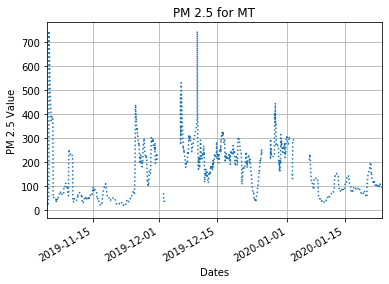

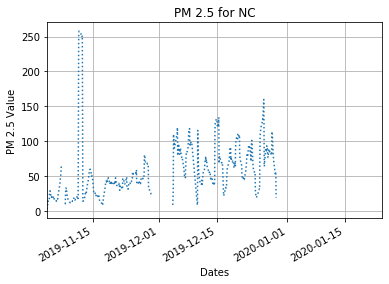

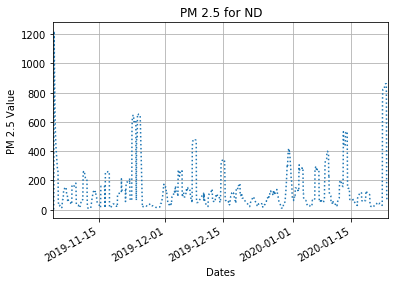

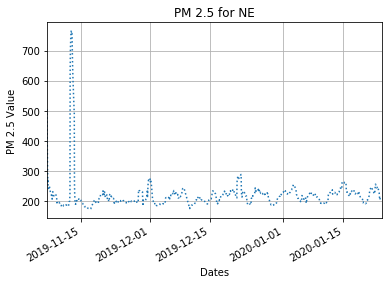

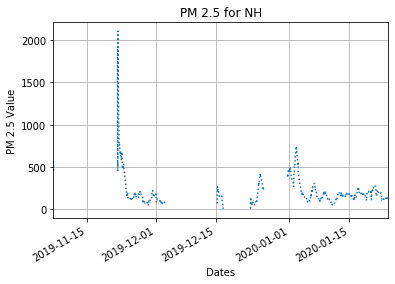

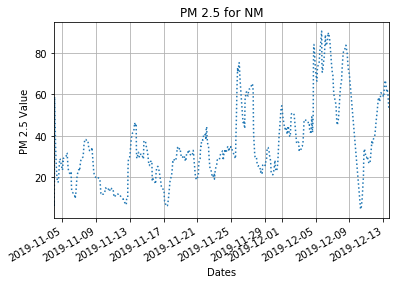

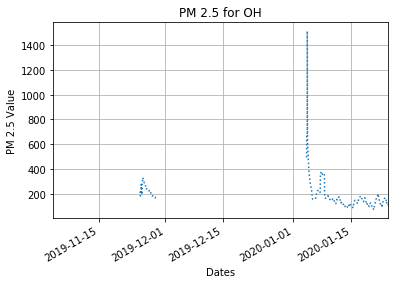

In [183]:
# this set is for daily PM 2.5 average for all modified gers
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM', 'OH']
data = data[(data.name == modified_gers[0]) | (data.name == modified_gers[1]) | (data.name == modified_gers[2]) | (data.name == modified_gers[3]) | (data.name == modified_gers[4]) | (data.name == modified_gers[5]) | (data.name == modified_gers[6]) | (data.name == modified_gers[7]) | (data.name == modified_gers[8]) | (data.name == modified_gers[9]) | (data.name == modified_gers[10]) | (data.name == modified_gers[11]) | (data.name == modified_gers[12]) | (data.name == modified_gers[13]) | (data.name == modified_gers[14]) | (data.name == modified_gers[15]) | (data.name == modified_gers[16]) | (data.name == modified_gers[17]) | (data.name == modified_gers[18]) | (data.name == modified_gers[19]) | (data.name == modified_gers[20]) | (data.name == modified_gers[21]) | (data.name == modified_gers[22]) | (data.name == modified_gers[23]) | (data.name == modified_gers[24]) | (data.name == modified_gers[25]) | (data.name == modified_gers[26]) | (data.name == modified_gers[27]) | (data.name == modified_gers[28])]

for name, sensor_data in data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.savefig("./modified_gers_pm_2_5/{}_pm_2_5.png".format(name), format='png')
    plt.show()
    
data = gold_data

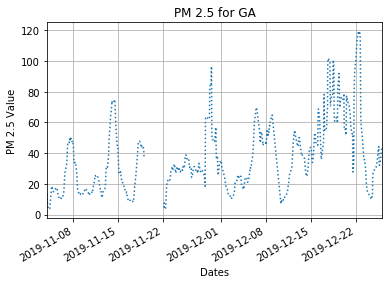

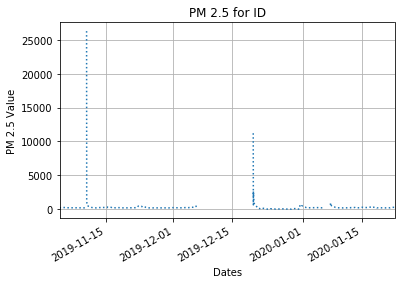

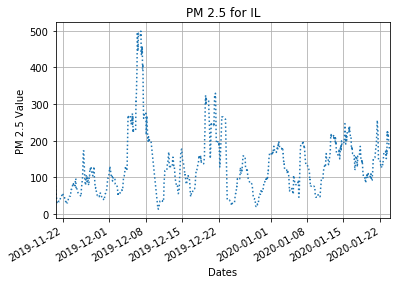

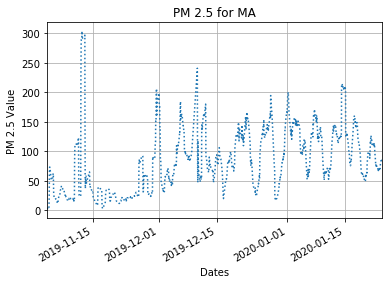

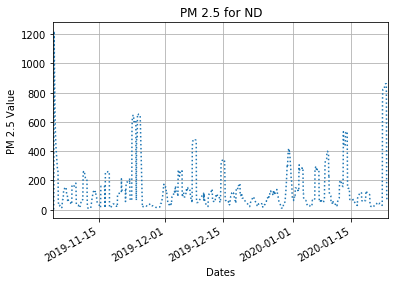

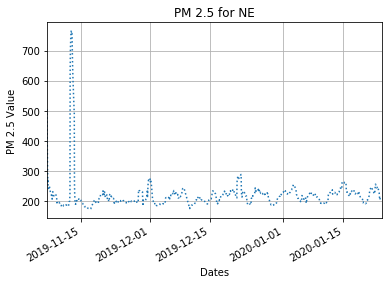

In [184]:
# this set is for daily PM 2.5 average for all modified gers 100% electrical heater
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

heater_only_modified_gers = ['GA', 'ID', 'IL', 'MA', 'ND', 'NE']
data = data[(data.name == heater_only_modified_gers[0]) | (data.name == heater_only_modified_gers[1]) | (data.name == heater_only_modified_gers[2]) | (data.name == heater_only_modified_gers[3]) | (data.name == heater_only_modified_gers[4]) | (data.name == heater_only_modified_gers[5])]

for name, sensor_data in data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.savefig("./heater_only_modified_gers_pm_2_5/{}_pm_2_5.png".format(name), format='png')
    plt.show()
    
data = gold_data

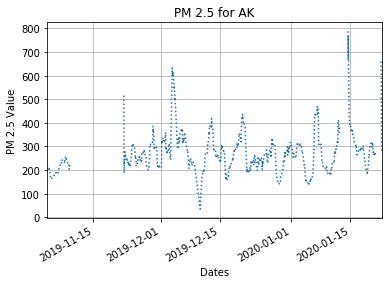

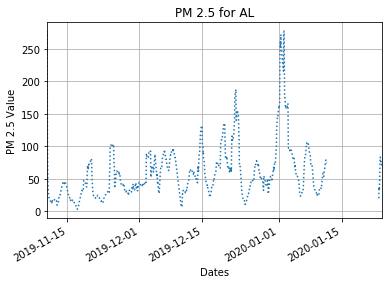

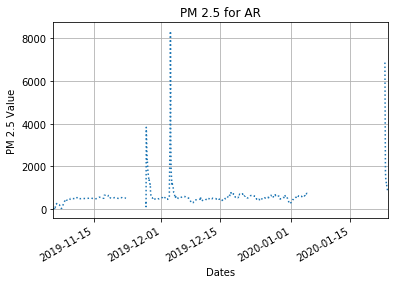

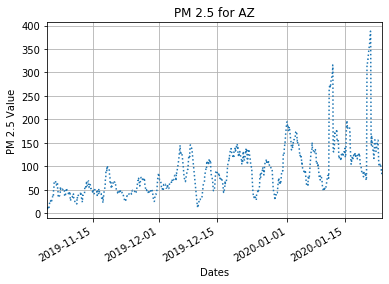

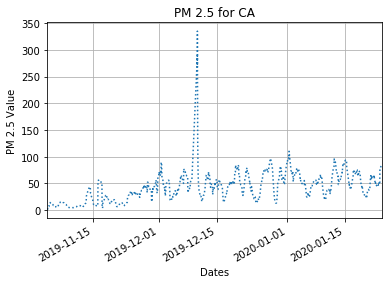

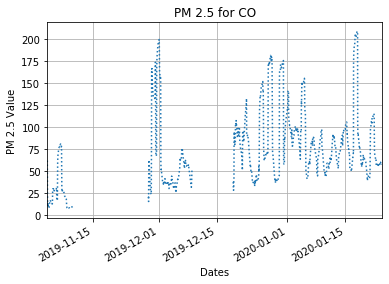

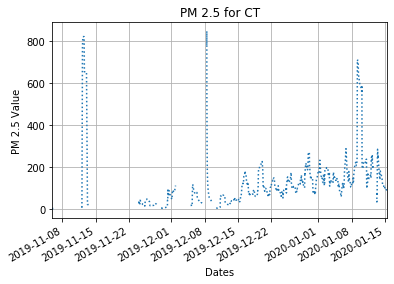

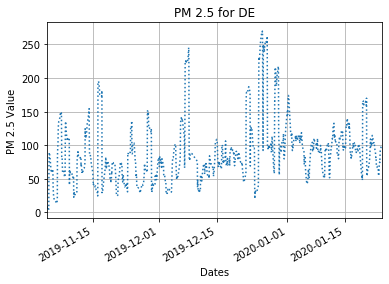

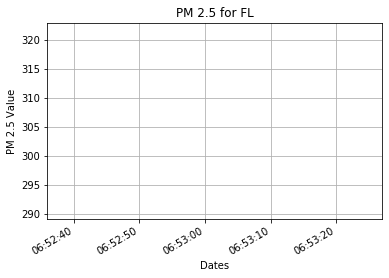

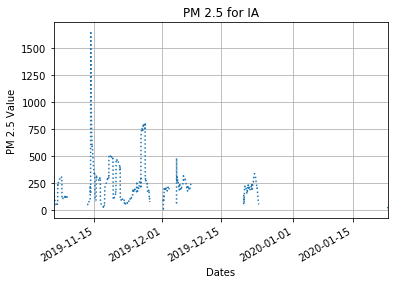

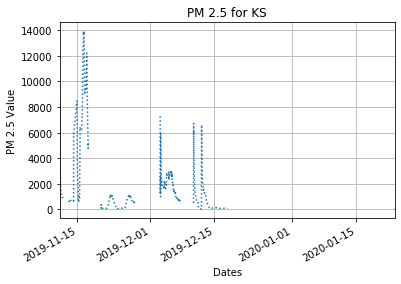

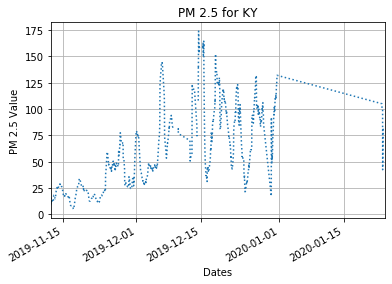

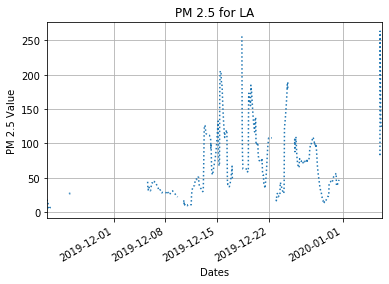

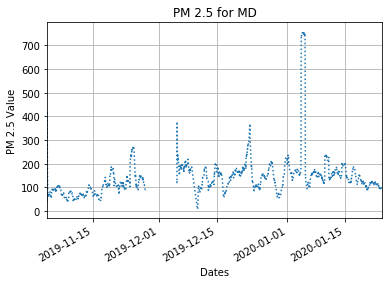

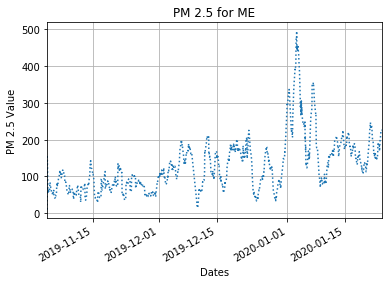

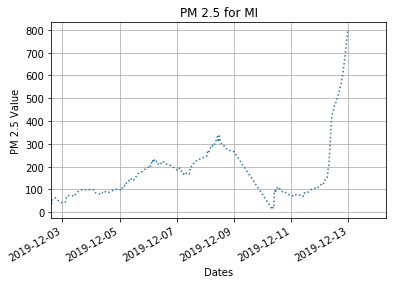

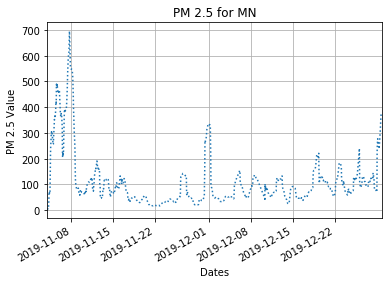

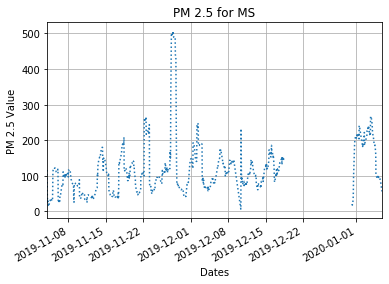

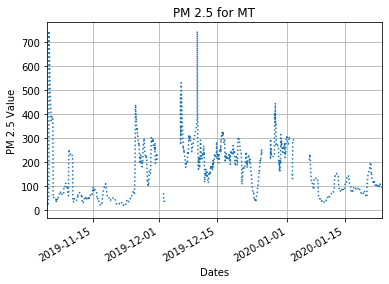

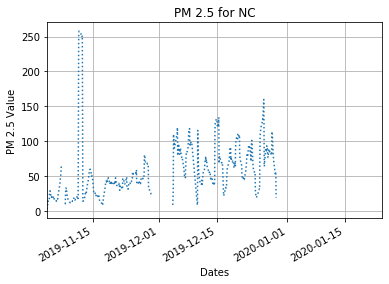

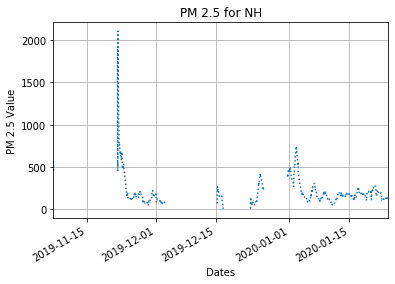

In [185]:
# this set is for daily PM 2.5 average for all modified gers 100% electrical heater
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

for name, sensor_data in data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.savefig("./hybrid_modified_gers_pm_2_5/{}_pm_2_5.png".format(name), format='png')
    plt.show()
    
data = gold_data

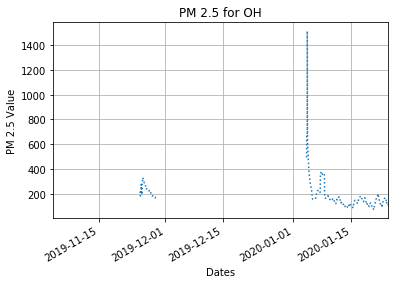

In [18]:
# this set is for daily PM 2.5 average for all modified gers 100% electrical heater
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

coal_only_modified_gers = ['OH']
data = data[(data.name == coal_only_modified_gers[0])]

for name, sensor_data in data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.savefig("./coal_only_modified_gers_pm_2_5/{}_pm_2_5.png".format(name), format='png')
    plt.show()
    
data = gold_data

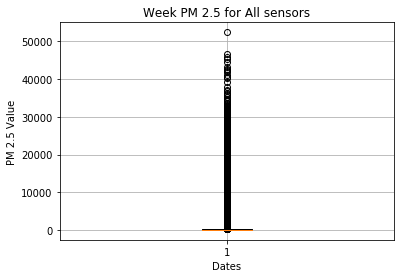

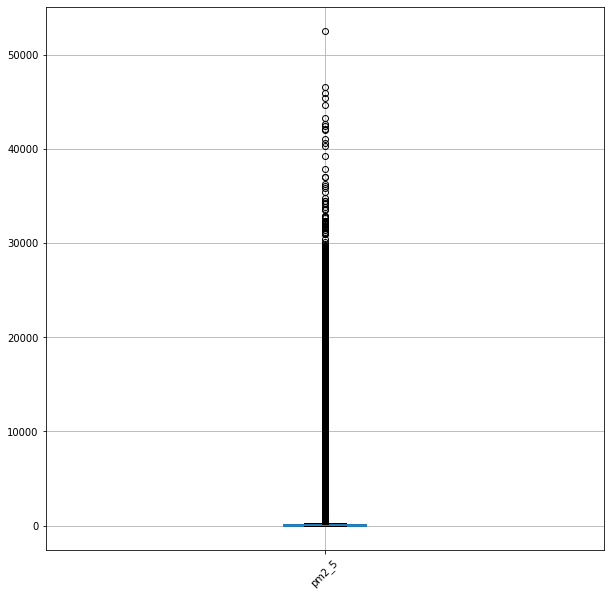

[[82.0, 76.0, 24.0, 40.0, 67.0, 62.0, 75.0, 78.0, 71.0, 32.0, 98.0, 89.0, 78.0, 67.0, 72.0, 82.0, 87.0, 66.0, 56.0, 52.0], [62, 5, 91, 25, 36, 32, 96, 95, 3, 90, 95, 32, 27, 55, 100, 15, 71, 11, 37, 21], [23, 89, 12, 78, 72, 89, 25, 69, 68, 86, 19, 49, 15, 16, 16, 75, 65, 31, 25, 52], [59, 73, 70, 16, 81, 61, 88, 98, 10, 87, 29, 72, 16, 23, 72, 88, 78, 99, 75, 30]]


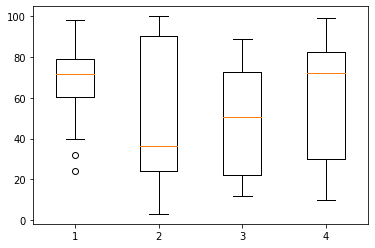

[[62.0,
  2.0,
  18.0,
  8.0,
  13.0,
  2.0,
  0.0,
  55.0,
  0.0,
  187.0,
  3.0,
  325.0,
  4.0,
  19.0,
  4.0,
  11.0,
  1.0,
  188.0,
  116.0,
  0.0,
  2.0,
  6.0,
  0.0,
  12.0,
  0.0,
  3.0,
  3.0,
  0.0,
  18.0,
  0.0,
  6.0,
  57.0,
  2.0,
  16.0,
  6.0,
  10.0,
  0.0,
  2.0,
  49.0,
  0.0,
  184.0,
  4.0,
  308.0,
  4.0,
  23.0,
  11.0,
  3.0,
  1.0,
  194.0,
  106.0,
  0.0,
  2.0,
  6.0,
  0.0,
  1.0,
  11.0,
  4.0,
  4.0,
  16.0,
  0.0,
  0.0,
  6.0,
  55.0,
  2.0,
  18.0,
  7.0,
  12.0,
  1.0,
  0.0,
  50.0,
  0.0,
  188.0,
  4.0,
  312.0,
  27.0,
  4.0,
  4.0,
  10.0,
  188.0,
  1.0,
  103.0,
  0.0,
  2.0,
  0.0,
  7.0,
  11.0,
  1.0,
  3.0,
  4.0,
  0.0,
  17.0,
  0.0,
  6.0,
  52.0,
  2.0,
  116.0,
  6.0,
  12.0,
  2.0,
  0.0,
  47.0,
  0.0,
  184.0,
  4.0,
  299.0,
  22.0,
  4.0,
  4.0,
  11.0,
  191.0,
  1.0,
  98.0,
  0.0,
  2.0,
  0.0,
  6.0,
  1.0,
  11.0,
  4.0,
  4.0,
  0.0,
  16.0,
  0.0,
  5.0,
  49.0,
  2.0,
  34.0,
  6.0,
  13.0,
  1.0,
  0.0,
  44.0,
  0.0,
 

In [60]:
# this set is for All sensors daily average PM 2.5 for 1 week
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o
data = gold_data
# box_plot_data
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All sensors')
plt.grid(True)

data = data[data.pm2_5 >= 0]

test = [data['pm2_5'].to_numpy().tolist()]

# for x in test:
#  print(x)

plt.boxplot(test)
plt.show()

data = gold_data
data.boxplot(column=['pm2_5'], rot=45,figsize=(10,10))
plt.show()

# test = data.boxplot(column=['pm2_5'], grid=True, rot=45, figsize=(1500,1500))
# data.groupby("name").get_group("AZ")["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
# data.groupby("pm2_5").rolling("7d").mean().plot(lineStyle=':')
# test = data.groupby("name").get_group("AZ")["pm2_5"].between_time('9:00','9:30').mean().plot(lineStyle=':')

# test

# test = data.groupby("pm2_5").as_matrix()
# numpy_data = data.as_matrix()
# test
# for name, sensor_data in data.groupby("name"):
#     data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
# plt.savefig("./all_week_sensors_pm_2_5/all_week_sensors_pm_2_5.png", format='png')
# plt.show()
    
# data = gold_data
    
# plt.boxplot(data.groupby("pm2_5"))
# plt.show()
# plt.show()
value1 = [82.0,76.0,24.0,40.0,67.0,62.0,75.0,78.0,71.0,32.0,98.0,89.0,78.0,67.0,72.0,82.0,87.0,66.0,56.0,52.0]
value2=[62,5,91,25,36,32,96,95,3,90,95,32,27,55,100,15,71,11,37,21]
value3=[23,89,12,78,72,89,25,69,68,86,19,49,15,16,16,75,65,31,25,52]
value4=[59,73,70,16,81,61,88,98,10,87,29,72,16,23,72,88,78,99,75,30]
 
box_plot_data=[value1,value2,value3,value4]
print(box_plot_data)
plt.boxplot(box_plot_data)
plt.show()

data = gold_data
test

[218.0, 212.0, 211.0, 214.0, 220.0, 216.0, 207.0, 206.0, 202.0, 205.0, 199.0, 199.0, 194.0, 193.0, 191.0, 190.0, 190.0, 189.0, 185.0, 184.0, 183.0, 182.0, 181.0, 182.0, 179.0, 180.0, 181.0, 179.0, 181.0, 176.0, 177.0, 178.0, 177.0, 173.0, 174.0, 172.0, 171.0, 171.0, 172.0, 171.0, 172.0, 171.0, 167.0, 169.0, 169.0, 168.0, 169.0, 169.0, 166.0, 170.0, 169.0, 169.0, 170.0, 168.0, 170.0, 168.0, 167.0, 167.0, 167.0, 165.0, 823.0, 812.0, 812.0, 766.0, 709.0, 643.0, 631.0, 594.0, 584.0, 513.0, 482.0, 449.0, 435.0, 416.0, 410.0, 394.0, 375.0, 362.0, 348.0, 335.0, 322.0, 317.0, 310.0, 297.0, 291.0, 286.0, 276.0, 272.0, 266.0, 260.0, 256.0, 245.0, 223.0, 212.0, 206.0, 190.0, 188.0, 188.0, 189.0, 187.0, 183.0, 186.0, 183.0, 182.0, 181.0, 180.0, 176.0, 175.0, 172.0, 173.0, 172.0, 170.0, 168.0, 169.0, 166.0, 167.0, 165.0, 166.0, 162.0, 164.0, 163.0, 157.0, 155.0, 154.0, 155.0, 157.0, 157.0, 153.0, 155.0, 153.0, 153.0, 152.0, 151.0, 152.0, 150.0, 150.0, 151.0, 149.0, 151.0, 149.0, 148.0, 147.0, 165.0

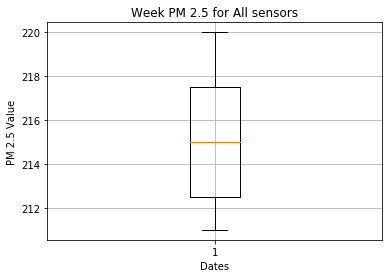

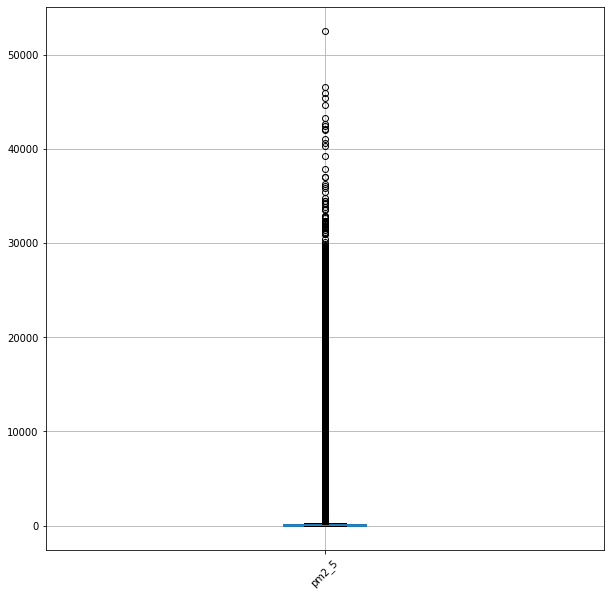

In [38]:
# this set is for All sensors daily average PM 2.5 for 1 week
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o
# https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/
data = gold_data

coal_only_modified_gers = ['OH']
data = data[(data.name == coal_only_modified_gers[0])]

# box_plot_data
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All sensors')
plt.grid(True)

data = data[data.pm2_5 >= 0]

test = data['pm2_5'].to_numpy().tolist()

print(test)

test_list = list(map(int, test))

print([test_list [:6]])

plt.boxplot([test_list [:6]])
plt.show()

data = gold_data
data.boxplot(column=['pm2_5'], rot=45,figsize=(10,10))
plt.show()
    
data = gold_data

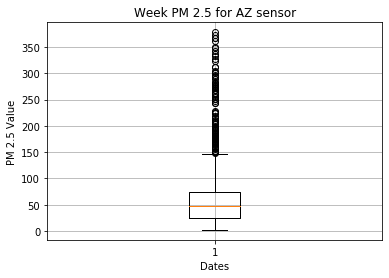

In [61]:
data = gold_data

plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for AZ sensor')
plt.grid(True)

data = data[data.pm2_5 >= 0]
test = data.groupby("name").get_group("AZ")["pm2_5"].between_time('9:00','9:30').to_numpy().tolist()

plt.boxplot(test)
plt.show()

data = gold_data

start = 2020-01-05T00:00:00Z
end = 2020-01-05T23:59:59Z
start = 2020-01-06T00:00:00Z
end = 2020-01-06T23:59:59Z
start = 2020-01-07T00:00:00Z
end = 2020-01-07T23:59:59Z
start = 2020-01-08T00:00:00Z
end = 2020-01-08T23:59:59Z
start = 2020-01-09T00:00:00Z
end = 2020-01-09T23:59:59Z
start = 2020-01-10T00:00:00Z
end = 2020-01-10T23:59:59Z
start = 2020-01-11T00:00:00Z
end = 2020-01-11T23:59:59Z


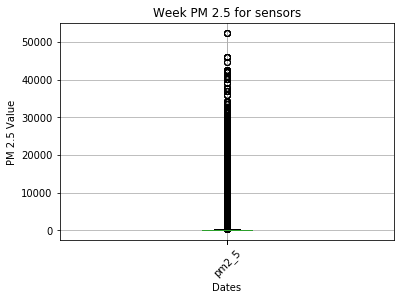

In [123]:
data = gold_data

plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
for day in days: 
    start = '2020-01-{}T00:00:00Z'.format(day)
    print('start = {}'.format(start))
    end = '2020-01-{}T23:59:59Z'.format(day)
    print('end = {}'.format(end))
    tmp = data[data.published >= start]
    tmp = data[data.published <= end]
    tmp.boxplot(column=['pm2_5'], rot=45,figsize=(10,10))
#     plt.show()
#     print(tmp)
#     plt.boxplot(tmp)

# for x in data['published']:
#     print(x)

# print(data['published'])
# print(data)

# data = data.groupby(data['pm2_5']).mean()
# print(test)

# plt.boxplot(data)
# plt.show()

data = gold_data

start = 2020-01-05T00:00:00Z
end = 2020-01-05T23:59:59Z
start = 2020-01-06T00:00:00Z
end = 2020-01-06T23:59:59Z
start = 2020-01-07T00:00:00Z
end = 2020-01-07T23:59:59Z
start = 2020-01-08T00:00:00Z
end = 2020-01-08T23:59:59Z
start = 2020-01-09T00:00:00Z
end = 2020-01-09T23:59:59Z
start = 2020-01-10T00:00:00Z
end = 2020-01-10T23:59:59Z
start = 2020-01-11T00:00:00Z
end = 2020-01-11T23:59:59Z
whiskers:  [0.0, 276.0, 0.0, 278.0, 0.0, 281.0, 0.0, 283.0, 0.0, 282.0, 0.0, 282.0, 0.0, 287.0]
caps:  [0.0, 276.0, 0.0, 278.0, 0.0, 281.0, 0.0, 283.0, 0.0, 282.0, 0.0, 282.0, 0.0, 287.0]
boxes:  [6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0]
medians:  [34.0, 34.0, 34.0, 35.0, 35.0, 35.0, 35.0]
means:  [108.00723195938421, 108.54491500230489, 108.8906269720817, 109.02187996168455, 108.83533010069345, 108.73169454327522, 109.12062395784832]
fliers:  []


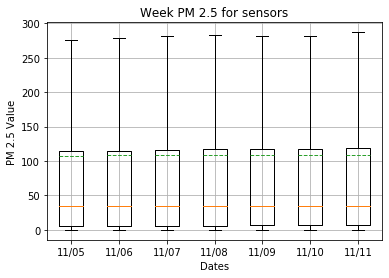

In [47]:
# This is the working boxplot for each day starting on 11/5-11/11 for all sensors

# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data

labels = ['11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
box_plots = []
for day in days: 
    start = '2020-01-{}T00:00:00Z'.format(day)
    print('start = {}'.format(start))
    end = '2020-01-{}T23:59:59Z'.format(day)
    print('end = {}'.format(end))
    tmp = data[data.published >= start]
    tmp = data[data.published <= end]
    box_plots.append(tmp['pm2_5'].to_numpy().tolist()) # either this line or below results in same results
#     box_plots.append(tmp['pm2_5']) # either this line or above results in same results
#     print(box_plots)
results = plt.boxplot(box_plots, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./all_week_all_sensors_boxplot_gers_pm_2_5/all_week_all_sensors_boxplot_gers_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

start = 2020-01-05T00:00:00Z
end = 2020-01-05T23:59:59Z
start = 2020-01-06T00:00:00Z
end = 2020-01-06T23:59:59Z
start = 2020-01-07T00:00:00Z
end = 2020-01-07T23:59:59Z
start = 2020-01-08T00:00:00Z
end = 2020-01-08T23:59:59Z
start = 2020-01-09T00:00:00Z
end = 2020-01-09T23:59:59Z
start = 2020-01-10T00:00:00Z
end = 2020-01-10T23:59:59Z
start = 2020-01-11T00:00:00Z
end = 2020-01-11T23:59:59Z
whiskers:  [118.0, 316.0, 118.0, 351.0, 21.0, 379.0, 26.0, 362.0, 45.0, 325.0, 44.0, 316.0, 45.0, 312.0]
caps:  [118.0, 316.0, 118.0, 351.0, 21.0, 379.0, 26.0, 362.0, 45.0, 325.0, 44.0, 316.0, 45.0, 312.0]
boxes:  [156.0, 156.0, 154.0, 152.0, 150.0, 146.0, 145.0]
medians:  [176.0, 178.0, 178.0, 175.0, 171.0, 167.0, 165.0]
means:  [215.5163188871054, 217.0013458950202, 237.31849348140994, 229.36388300127172, 221.19312429165092, 212.64646946564886, 208.63344091360477]
fliers:  []


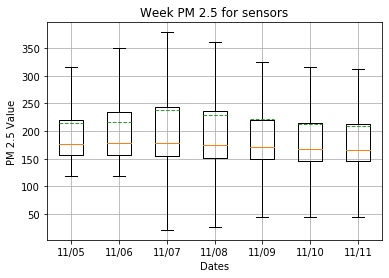

In [48]:
# This is the working boxplot for each day starting on 11/5-11/11 coal only

# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
coal_only_modified_gers = ['OH']
data = data[(data.name == coal_only_modified_gers[0])]

labels = ['11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
box_plots = []
for day in days: 
    start = '2020-01-{}T00:00:00Z'.format(day)
    print('start = {}'.format(start))
    end = '2020-01-{}T23:59:59Z'.format(day)
    print('end = {}'.format(end))
    tmp = data[data.published >= start]
    tmp = data[data.published <= end]
    box_plots.append(tmp['pm2_5'].to_numpy().tolist()) # either this line or below results in same results
#     box_plots.append(tmp['pm2_5']) # either this line or above results in same results
#     print(box_plots)
results = plt.boxplot(box_plots, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./all_week_coal_only_boxplot_gers_pm_2_5/all_week_coal_only_boxplot_gers_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

start = 2020-01-05T00:00:00Z
end = 2020-01-05T23:59:59Z
start = 2020-01-06T00:00:00Z
end = 2020-01-06T23:59:59Z
start = 2020-01-07T00:00:00Z
end = 2020-01-07T23:59:59Z
start = 2020-01-08T00:00:00Z
end = 2020-01-08T23:59:59Z
start = 2020-01-09T00:00:00Z
end = 2020-01-09T23:59:59Z
start = 2020-01-10T00:00:00Z
end = 2020-01-10T23:59:59Z
start = 2020-01-11T00:00:00Z
end = 2020-01-11T23:59:59Z
whiskers:  [0.0, 327.0, 0.0, 329.0, 0.0, 329.0, 0.0, 329.0, 0.0, 327.0, 0.0, 327.0, 0.0, 327.0]
caps:  [0.0, 327.0, 0.0, 329.0, 0.0, 329.0, 0.0, 329.0, 0.0, 327.0, 0.0, 327.0, 0.0, 327.0]
boxes:  [22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
medians:  [55.0, 55.0, 56.0, 56.0, 55.0, 55.0, 56.0]
means:  [150.68075360359708, 150.94660677467854, 150.80850060991295, 150.34336325081046, 149.95848130251693, 149.4878952679615, 149.57726412942864]
fliers:  []


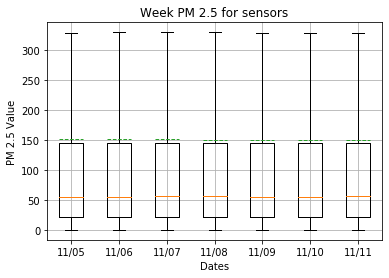

In [49]:
# This is the working boxplot for each day starting on 11/5-11/11 hybrid

# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

labels = ['11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
box_plots = []
for day in days: 
    start = '2020-01-{}T00:00:00Z'.format(day)
    print('start = {}'.format(start))
    end = '2020-01-{}T23:59:59Z'.format(day)
    print('end = {}'.format(end))
    tmp = data[data.published >= start]
    tmp = data[data.published <= end]
    box_plots.append(tmp['pm2_5'].to_numpy().tolist()) # either this line or below results in same results
#     box_plots.append(tmp['pm2_5']) # either this line or above results in same results
#     print(box_plots)
results = plt.boxplot(box_plots, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./all_week_hybrid_boxplot_gers_pm_2_5/all_week_hybrid_boxplot_gers_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

In [ ]:
# This is the working boxplot for each day starting on 11/5-11/11 electric only

# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
heater_only_modified_gers = ['GA', 'ID', 'IL', 'MA', 'ND', 'NE']
data = data[(data.name == heater_only_modified_gers[0]) | (data.name == heater_only_modified_gers[1]) | (data.name == heater_only_modified_gers[2]) | (data.name == heater_only_modified_gers[3]) | (data.name == heater_only_modified_gers[4]) | (data.name == heater_only_modified_gers[5])]

labels = ['11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
box_plots = []
for day in days: 
    start = '2020-01-{}T00:00:00Z'.format(day)
    print('start = {}'.format(start))
    end = '2020-01-{}T23:59:59Z'.format(day)
    print('end = {}'.format(end))
    tmp = data[data.published >= start]
    tmp = data[data.published <= end]
    box_plots.append(tmp['pm2_5'].to_numpy().tolist()) # either this line or below results in same results
#     box_plots.append(tmp['pm2_5']) # either this line or above results in same results
#     print(box_plots)
results = plt.boxplot(box_plots, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./all_week_electric_boxplot_gers_pm_2_5/all_week_electric_boxplot_gers_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

start = 2020-01-05T00:00:00Z
end = 2020-01-05T23:59:59Z
start = 2020-01-06T00:00:00Z
end = 2020-01-06T23:59:59Z
start = 2020-01-07T00:00:00Z
end = 2020-01-07T23:59:59Z
start = 2020-01-08T00:00:00Z
end = 2020-01-08T23:59:59Z
start = 2020-01-09T00:00:00Z
end = 2020-01-09T23:59:59Z
start = 2020-01-10T00:00:00Z
end = 2020-01-10T23:59:59Z
start = 2020-01-11T00:00:00Z
end = 2020-01-11T23:59:59Z
whiskers:  [0.0, 276.0, 0.0, 278.0, 0.0, 281.0, 0.0, 283.0, 0.0, 282.0, 0.0, 282.0, 0.0, 287.0]
caps:  [0.0, 276.0, 0.0, 278.0, 0.0, 281.0, 0.0, 283.0, 0.0, 282.0, 0.0, 282.0, 0.0, 287.0]
boxes:  [6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0]
medians:  [34.0, 34.0, 34.0, 35.0, 35.0, 35.0, 35.0]
means:  [108.00723195938421, 108.54491500230489, 108.8906269720817, 109.02187996168455, 108.83533010069345, 108.73169454327522, 109.12062395784832]
fliers:  [308.0, 308.0, 308.0, 308.0, 308.0, 308.0, 308.0]


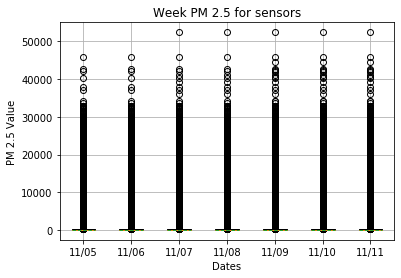

In [34]:
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data

labels = ['11/05', '11/06', '11/07', '11/08', '11/09', '11/10', '11/11']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
box_plots = []
for day in days: 
    start = '2020-01-{}T00:00:00Z'.format(day)
    print('start = {}'.format(start))
    end = '2020-01-{}T23:59:59Z'.format(day)
    print('end = {}'.format(end))
    tmp = data[data.published >= start]
    tmp = data[data.published <= end]
#     box_plots.append(tmp['pm2_5'].to_numpy().tolist())
    box_plots.append(tmp['pm2_5'])
#     print(box_plots)
results = plt.boxplot(box_plots, showfliers=True, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

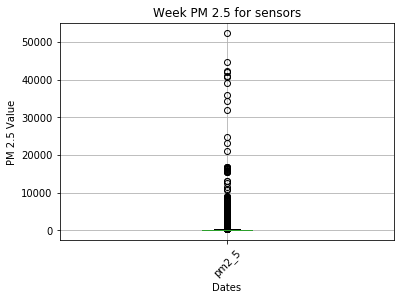

In [13]:
data = gold_data

plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
data = data[data.pm2_5 >= 0]
data = data[data.published >= '2020-01-05T00:00:00Z']
data = data[data.published <= '2020-01-11T23:59:59Z']

data.boxplot(column=['pm2_5'], rot=45,figsize=(10,10), return_type=None)

data = gold_data